# Bahcall model + thin dark disk

In [6]:
%matplotlib notebook
from __future__ import division    #for division operator
import math, numpy as np
from sympy.mpmath import *
from astropy import constants as const
from astropy import units as u
from scipy.integrate import quad, odeint
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from scipy.interpolate import InterpolatedUnivariateSpline

infilepath = '/Users/Jatan/Desktop/DDDM/Data/'
outfilepath = '/Users/Jatan/Desktop/DDDM/Plots/dark_disk/'

#----------------definitions-------------------------

data_hip_A = infilepath + 'data_AstarsCorr.txt'   
Gal_lat_A, z_coord_A, vel_A = np.loadtxt(data_hip_A, delimiter=",", skiprows=1, usecols=(2, 5, 17), unpack=True)
zsun = 7 #26  #height of the sun (in pc)
z_A = z_coord_A + 7   # z = z' + zsun  (in pc)
lowlat_A_stars = []
for i in range(len(Gal_lat_A)):
	if (abs(Gal_lat_A[i]) < 12):
		lowlat_A_stars.append(i)
vel_z_A = [vel_A[j] for j in lowlat_A_stars]

G = (const.G.to('pc3 /solMass s2')).value
scaling = (1* u.km).to('pc').value / np.sqrt(8*np.pi*G) #Definition of potential is off by a factor of 4 pi G, because this factor has been absorbed into the definition of sigma
rescaling = 4*np.pi*G / pow((1* u.km).to('pc').value, 2)   #to obtain phi in km^2/s^2

### PJ Solver

In [35]:
#index =   [ 0,      1,     2,      3,      4,      5,      6,      7,      8,      9,    10,     11,    12,    13,     14,     15,         16]
rho0_old = [0.021, 0.016, 0.012, 0.0009, 0.0006, 0.0031, 0.0015, 0.0020, 0.0022, 0.007, 0.0135, 0.006, 0.002, 0.0035, 0.0001, 0.0, 0.0] #* u.solMass/((u.pc)**3)
sigma_old = [4.0, 7.0, 9.0, 40.0, 20.0, 7.5, 10.5, 14.0, 18.0, 18.5, 18.5, 20.0, 20.0, 37.0, 100.0, 130, 0.0] #* u.km/u.s
vel_disp_old =[pow(x * scaling, 2) for x in sigma_old]

def func_dark(y, z, rho_dh, rho_dd):
  	y1, y2 = y
  	rho0_old[15] = rho_dh
  	rho0_old[16] = rho_dd
  	return [y2, sum([x*exp(-y1/(2*y)) for x,y in zip(rho0_old, vel_disp_old)])]


def ode_solver(y, z1, z, alpha, sigmadd_initial, hdd_initial, rho_dh, rho_dd):
	i = 0
	limit = 0
	for i in range(20):
		sol2 = odeint(func_dark, y, z1, args=(rho_dh[i], rho_dd[i]))       #ensure it takes different values 
		sol_dd = np.concatenate((list(reversed(sol2[:,0])), sol2[:,0]), axis=0)      #workaround for obtaining symmetric plot
		phi_dd = InterpolatedUnivariateSpline(z, sol_dd)
		rho_dh.append(rhoDH_constrain / exp(-phi_dd(2500)/(2*vel_disp_old[15])))
		rho_z_dd = InterpolatedUnivariateSpline(z1, [rho0_old[16]*exp(-x/(2*vel_disp_old[16])) for x in sol2[:,0]])
		sigmadd = 2*rho_z_dd.integral(0, 3000)
		rho_dd.append(pow((sigmadd_initial/sigmadd), alpha)*rho_dd[i])
		if (abs(sigmadd - sigmadd_initial)/sigmadd_initial) <= 0.01 :
			break
		else:
			i += 1
	def func_hsol(x):
		return rho_z_dd(x) - rho0_old[16]*pow(sech(1/2), 2)
	#if (sigmadd_initial/hdd_initial) < 1:
		#limit = 0
	hdd_sech = brentq(func_hsol, limit, hdd_initial)

	return sigmadd, hdd_sech, sol_dd


"""Kernel Density Estimation with Scipy"""
from scipy.stats import gaussian_kde
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth, **kwargs) #/ x.std(ddof=1)
    return kde.evaluate(x_grid)

### Constructing observed density of A-stars 

In [8]:
def rho_obs_Astars(samples, frac, z_trunc, z_A):
    pdf_z_A = []
    Delta_list_z = []
    rho_obs = kde_scipy(z_A, z_trunc, bandwidth='silverman')     #kde for observed A-stars; need to normalize for density!
    z_A_sample = []                                                                                                 
    for i in xrange(samples):
        z_A_sample.append(np.random.choice(z_A, frac, replace=False))  
    for i in xrange(samples):
        pdf_z_A.append(kde_scipy(z_A_sample[i], z_trunc, bandwidth='silverman'))  #fix a gaussian kde for each sample to obtain a distribution									
                                                
    for i in xrange(len(z_trunc)):         #create a list of values at a particular z for different sample distributions
        Delta_list_z.append([pdf_z_A[j][i] for j in xrange(samples)])

    Delta_rho_z =[2*np.std(Delta_list_z[i], ddof=1) for i in xrange(len(z_trunc))]  
    rho_err_max = rho_obs+Delta_rho_z
    rho_err_min = rho_obs-Delta_rho_z
    
    return rho_obs, rho_err_max, rho_err_min, Delta_rho_z

### Modeling density of A-stars using kinematic information

In [25]:
def rho_f_Astars(samples, frac, z, vel_z, vel_z_A, phi_dd):
    norm_Astars = 0.005151 #* u.solMass/((u.pc)**3)
    velmin, velmax = min(vel_z_A), max(vel_z_A)  
    pdf_vel_A = []
    norm_vel = []
    result = []
    Delta_list_vel = []
    
    vel_A_sample = []
    for i in xrange(samples):
        vel_A_sample.append(np.random.choice(vel_z_A, frac, replace=False))
    for i in xrange(samples):
        pdf_vel_A.append(kde_scipy(vel_A_sample[i], vel_z, bandwidth='silverman'))   #pdf_vel_A[i][j] is a 100 x (371) array for A-stars 
    v_mean = [vel_z[np.where(pdf_vel_A[i] == max(pdf_vel_A[i]))[0][0]] for i in xrange(samples)] #position of max velocity 

    f_w = [InterpolatedUnivariateSpline(vel_z-v_mean[i], pdf_vel_A[i]) for i in xrange(samples)]
#     def func_vel_check(w, s_i):				  #s_i -> sample index
#         return f_w[s_i](w)  #f_w(w) integrates to 1 (sanity check!)
#     norm_vel.append([quad(func_vel_check, velmin, velmax, args=(j,))[0] for j in xrange(no_of_samples)])

    def func_vel(w, s_i, potential):				  #s_i -> sample index
        return f_w[s_i](np.sqrt(pow(w, 2) + 2*potential))  #f_w(w) integrates to 1 (sanity check!)

    for j in xrange(samples):
        result.append([quad(func_vel, velmin, velmax, args=(j, phi_dd(i)))[0] for i in z])

    for i in xrange(len(z)):
        Delta_list_vel.append([norm_Astars*result[j][i] for j in xrange(samples)])   
    
    rho_f = [np.average(Delta_list_vel[i]) for i in xrange(len(z))]  #constructed density f, consider mean of all samples
    rho_f_norm = [norm_Astars*rho_f[i]/max(rho_f) for i in xrange(len(rho_f))]
    Delta_rho_vel =[np.std(Delta_list_vel[i], ddof=1) for i in xrange(len(z))]  
    vel_err_max = [(rho_f_norm[i] + Delta_rho_vel[i]) for i in xrange(len(z))]
    vel_err_min = [(rho_f_norm[i] - Delta_rho_vel[i]) for i in xrange(len(z))]
    
    return rho_f_norm, vel_err_max, vel_err_min, Delta_rho_vel

In [48]:
def rho_f_Astars_approx(z, vel_z, vel_z_A, phi_dd):
    norm_Astars = 0.005151 #* u.solMass/((u.pc)**3)
    velmin, velmax = min(vel_z_A), max(vel_z_A)  

    pdf_vel_A = kde_scipy(vel_z_A, vel_z, bandwidth='silverman')
    v_mean = vel_z[np.where(pdf_vel_A == max(pdf_vel_A))[0][0]]  #position of max velocity 

    f_w = InterpolatedUnivariateSpline(vel_z-v_mean, pdf_vel_A)

    def func_vel(w, potential):                  #s_i -> sample index
        return f_w(np.sqrt(pow(w, 2) + 2*potential))  #f_w(w) integrates to 1 (sanity check!)

    result = [quad(func_vel, velmin, velmax, args=(phi_dd(i),))[0] for i in z]
    rho_f = [norm_Astars*result[i] for i in range(len(result))] #constructed density f
    rho_f_norm = [norm_Astars*rho_f[i]/max(rho_f) for i in xrange(len(rho_f))]

    return rho_f_norm

### 'Main' function


In [10]:
y0 = [0.0, 0.0] 
z1 = np.linspace(0, 3000, 3000)    
z2 = np.linspace(-3000, -1, 3000)  #note: scipy's interp1d only interpolates for a monotonic array, hence the -0.01 instead of 0; extend to 170pc!
z = np.concatenate((z2, z1), axis=0) 
rhoDH_initial = 0.008 #* u.solMass/((u.pc)**3) initial guess for dark halo disk
rhoDH_constrain = 0.008 #* u.solMass/((u.pc)**3)
alpha = 0.37

In [11]:
no_of_samples = 100
q = 1/2  						
zmin, zmax = min(z_A), max(z_A) 
z_grid = []
for i in range(len(z)):
	if zmin <= z[i] <= zmax:
		z_grid.append(z[i])
frac_z_A = int(q*len(z_A))  
velmin, velmax = min(vel_z_A), max(vel_z_A)  
vel_grid = np.linspace(velmin, velmax, len(vel_z_A))
frac_vel_A = int(q*len(vel_z_A))

In [12]:
rho_obs, rho_err_max, rho_err_min, Delta_rho_z = rho_obs_Astars(no_of_samples, frac_z_A, z_grid, z_A)

In [33]:
sigmaDD_initial = np.linspace(0.1, 10, 10);   #parameters for dark disk
hDD_initial = [np.logspace(np.log10(0.2), np.log10(40000*pow((0.1/s), 0.9)), 10) for s in sigmaDD_initial];

# sigmaDD_initial = [10]
# hDD_initial = [[1, 10]]
#print range(len(sigmaDD_initial)), range(len(hDD_initial[0]))

In [49]:
sigma_flag = []
h_flag = []
chi_sq_flag = []
for i in xrange(len(sigmaDD_initial)):
    for j in xrange(len(hDD_initial[0])):
        rhoDD_initial = (sigmaDD_initial[i]/(4*hDD_initial[i][j]))  #* u.solMass/((u.pc)**3) initial guess for thin dark disk
        sigma_old[16] = hDD_initial[i][j]*(1* u.pc).to('km').value*np.sqrt(8*np.pi*G*rhoDD_initial)
        vel_disp_old[16] = pow(sigma_old[16] * scaling, 2)
        rhoDH = [rhoDH_initial] #make array
        rhoDD = [rhoDD_initial]
        sigmaDD, hDD, sol_DD = ode_solver(y0, z1, z, alpha, sigmaDD_initial[i], hDD_initial[i][j], rhoDH, rhoDD)
        
        phi_DD = InterpolatedUnivariateSpline(z, rescaling*sol_DD)
        rho_f = rho_f_Astars_approx(z_grid, vel_grid, vel_z_A, phi_DD)
        chi_sq = np.sum([(pow(rho_obs[k] - rho_f[k], 2)/ (2*pow(Delta_rho_z[k], 2))) for k in xrange(len(z_grid))])
        #rho_f, vel_err_max, vel_err_min, Delta_rho_vel = rho_f_Astars(no_of_samples, frac_vel_A, z_grid, vel_grid, vel_z_A, phi_DD) #1 loops, best of 3: 1min 51s per loop
        #chi_sq = np.sum([(pow(rho_obs[k] - rho_f[k], 2)/(pow(Delta_rho_z[k], 2) + pow(Delta_rho_vel[k], 2))) for k in xrange(len(z_grid))])
        
        sigma_flag.append(sigmaDD)
        h_flag.append(hDD)
        chi_sq_flag.append(chi_sq)
        print i, j, chi_sq 

0 0 2205.836746
0 1 1877.19960572


In [12]:
%timeit rho_f_Astars(no_of_samples, frac_vel_A, z_grid, vel_grid, vel_z_A, phiDD_final[0][0]) #1 loops, best of 3: 2mins per loop

1 loops, best of 3: 2min 6s per loop


In [43]:
newfile = '/Users/Jatan/Desktop/DDDM/Results/chi_sq_10_10.txt'
np.savetxt(newfile, np.c_[sigma_flag, h_flag, chi_sq_flag], fmt='%.3f', header='created in python for a chi-square fit \n sigma_DD    h_DD     chi_sq')

In [44]:
np.sqrt(170)/170, max(Delta_rho_z)/rho_obs[np.where(Delta_rho_z == max(Delta_rho_z))[0][0]], max(Delta_rho_vel)/rho_f[np.where(Delta_rho_z == max(Delta_rho_z))[0][0]]

(0.076696498884737049, 0.0839625839392725, 0.077950156826361153)

### Plotting routine for comparing observed and constructed densities


<IPython.core.display.Javascript object>


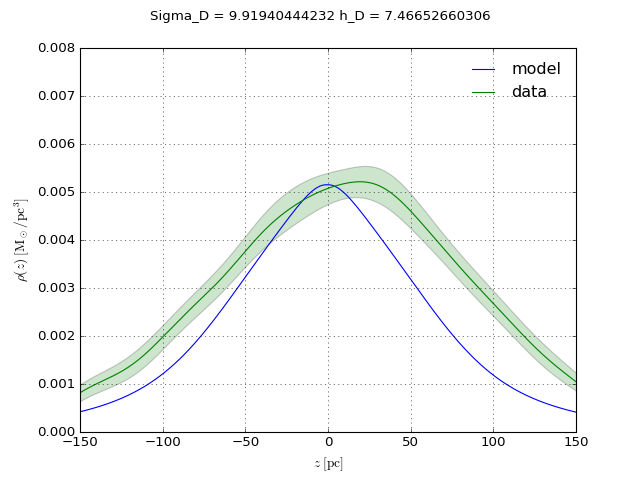

In [51]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

#majorLocator = MultipleLocator(0.0005)
#majorFormatter = FormatStrFormatter('%.4f')
#minorLocator = MultipleLocator(0.0001)

fig, ax = plt.subplots(1, 1)

#ax.yaxis.set_major_locator(majorLocator)
#ax.yaxis.set_major_formatter(majorFormatter)

# for the minor ticks, use no labels; default NullFormatter
#ax.yaxis.set_minor_locator(minorLocator)

#bw_A = 20 #bin width
#bin_list_A = np.arange(zmin, zmax+bw_A, bw_A)
#plt.hist(z_A, bin_list_A, normed = 'True', color='gray', histtype='stepfilled', alpha=0.3)   #normed = 'True'

#plt.fill_between(z_grid, vel_err_max, vel_err_min, facecolor='b', alpha=0.2)
plt.plot(z_grid, rho_f,'b', label='model')
plt.fill_between(z_grid, rho_err_max, rho_err_min, facecolor='g', alpha=0.2)
plt.plot(z_grid, rho_obs ,'g', label='data')
plt.ylabel(r'$\rho(z) \; [ \mathrm{M_\odot/pc^3} ]$')   
plt.xlabel(r'$z \; [ \mathrm{pc} ]$')
plt.xlim(-150, 150)
plt.ylim(0, 0.008)
plt.suptitle(r'Sigma_D = %s' %str(sigma_flag[1]) +' h_D = %s' %str(h_flag[1]))
plt.legend(loc='best', frameon=False)
plt.grid()
plt.show()
plt.savefig(outfilepath + 'rho_final_S10_h10.pdf')  #'multi_component_full.pdf'  #'rho_combined_line.pdf'

### Plotting routine for verifying functional form of dark disk density

In [ ]:
plt.plot(z1, rho_z(z1),'b', label='calculated')
plt.plot(z1, [(sigmaDD/(4*hDD_sech))*pow(sech(test_grid[i]/(2*hDD_sech)), 2) for i in xrange(len(test_grid))],'r', label='approx', linestyle='--')
plt.xlim(0, 100)
plt.ylabel(r'$\rho(z) \; [ \mathrm{M_\odot/pc^3} ]$')   
plt.xlabel(r'$z \; [ \mathrm{pc} ]$')
plt.suptitle(r'Sigma_D = %s' %str(sigmaDD) +' h_D = %s' %str(hDD_sech))
plt.legend(loc='best', frameon=False)
plt.grid()
plt.savefig(outfilepath + 'sech_profile_check.pdf')

In [ ]:
newfile3 = outfilepath + 'pj_solver_verification_2.txt' 
np.savetxt(newfile3, np.c_[z1, rho_dd(z1), phi_dd(z1)], fmt='%e', header='created in python with cuts following 1604.01407 \n z_1    rho_z     phi_z')